In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from utils.kalman import calculate_altitude, hx, fx
from utils.view_plot import plot_predicted_positions

## Data Upload

In [12]:
# Load the sensor data
data_w_up = pd.read_csv('../utils/spiral_data/sensor_data_up_w.csv')
data_b_up = pd.read_csv('../utils/spiral_data/sensor_data_up_b.csv')

## Constants

In [13]:
R = 8.25  # Radius
alpha = 0.67  # Vertical rise rate
R_const = 287.05
g = 9.80665 # Gravity constant

# Adjust initial positions and velocities for stability at the start
initial_x = 0.0
initial_y = 0.0
initial_z = alpha
initial_vertical_velocity = 0.0

dt = 1.0 / 25

# Unscented Kalman Filter

In [14]:
P0 = data_w_up['Pressure'][0]
T0 = data_w_up['Temperature'][0]

n_states = 13
points = MerweScaledSigmaPoints(n=n_states, alpha=0.1, beta=2.0, kappa=-1.0)
kf = UKF(dim_x=13, dim_z=3, fx=fx, hx=hx, dt=dt, points=points)
kf.x = np.array([initial_x, initial_y, initial_z, 0, 0, initial_vertical_velocity, 1, 0, 0, 0, 0, 0, 0])

# Improve filter stability by adjusting noise
kf.P *= 0.1
kf.R = np.diag([0.15, 0.15, 0.001])  # Adjusted measurement noise
kf.Q = np.eye(n_states) * 0.01  # Improved process noise setup

In [15]:

positions = []

for index, row in data_w_up.iterrows():
    accel = np.array([row['Accel_X'], row['Accel_Y'], row['Accel_Z']])
    mag_x = row['Magneto_X']
    mag_y = row['Magneto_Y']
    mag_z = row['Magneto_Z']
    pressure = row['Pressure']

    altitude = calculate_altitude(pressure, P0, T0, g, R_const)
    z = np.array([0, 0, altitude])
    
    kf.predict(dt=dt, fx=fx, accel=accel, g=g)
    kf.update(z)

    positions.append(kf.x[:3])

positions = np.array(positions)

In [16]:
print(positions[:5])

[[ 2.88254046e-05 -1.21386339e-03  6.62573165e-03]
 [-1.01444516e-03 -2.33782465e-03 -5.37393288e+00]
 [-2.08991053e-03 -3.50129488e-03 -5.82305869e+00]
 [-1.94323323e-03 -5.47097638e-03 -5.86057351e+00]
 [-1.53148214e-03 -9.02394458e-03 -5.86333990e+00]]


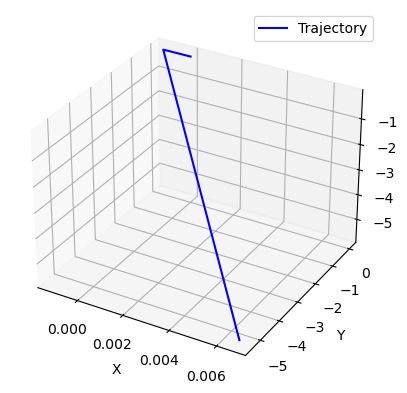

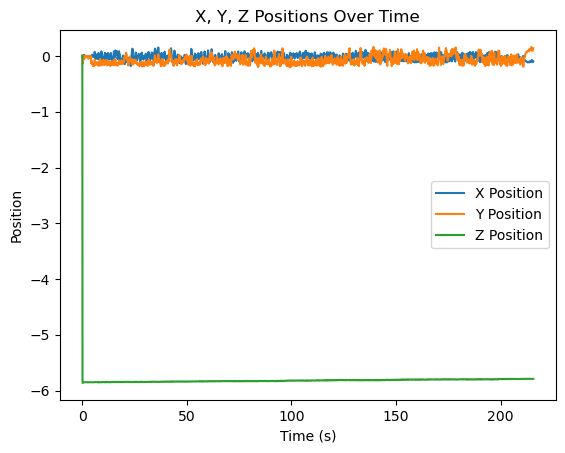

In [17]:
plot_predicted_positions(positions)

time_steps = np.arange(positions.shape[0]) * dt

plt.figure()
plt.plot(time_steps, positions[:, 0], label='X Position')
plt.plot(time_steps, positions[:, 1], label='Y Position')
plt.plot(time_steps, positions[:, 2], label='Z Position')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.title('X, Y, Z Positions Over Time')
plt.legend()
plt.show()

#### Another trial

In [18]:
P0 = data_b_up['Pressure'][0]
T0 = data_b_up['Temperature'][0]

n_states = 13
points = MerweScaledSigmaPoints(n=n_states, alpha=0.1, beta=2.0, kappa=-1.0)
kf = UKF(dim_x=13, dim_z=3, fx=fx, hx=hx, dt=dt, points=points)
kf.x = np.array([0, 0, 0, 0, 0, alpha, 1, 0, 0, 0, 0, 0, 0])
kf.P *= 0.1
kf.R = np.diag([1.0, 1.0, 0.1])  # Lower noise for altitude
kf.Q = np.eye(n_states) * 0.1

positions = []

for index, row in data_b_up.iterrows():
    Accel_X, Accel_Y, Accel_Z = row['Accel_X'], row['Accel_Y'], row['Accel_Z']
    mag_x = row['Magneto_X']
    mag_y = row['Magneto_Y']
    mag_z = row['Magneto_Z']
    pressure = row['Pressure']

    altitude = calculate_altitude(pressure, P0, T0, g, R_const)

    z = np.array([mag_x, mag_y, altitude])

    kf.predict(dt=dt, fx=fx, accel=accel, g=g)
    kf.update(z)

    positions.append(kf.x[:3])

positions = np.array(positions)

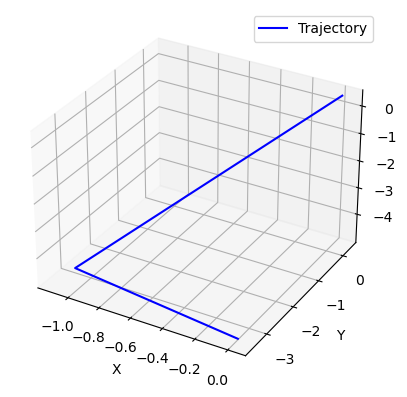

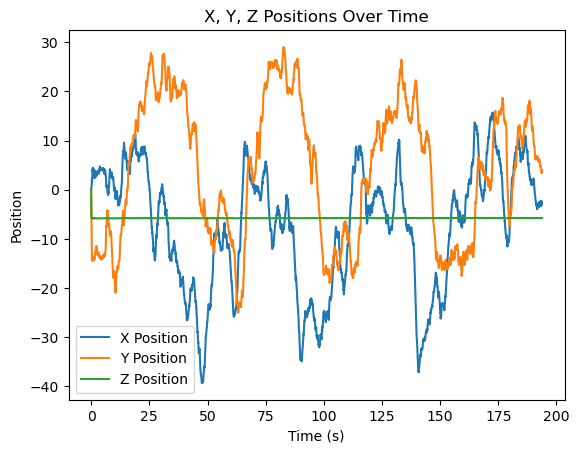

In [19]:
# 3D Plot of estimated spiral trajectory
plot_predicted_positions(positions)

# 2D Plot of X, Y, Z positions over time
time_steps = np.arange(positions.shape[0]) * dt

plt.figure()
plt.plot(time_steps, positions[:, 0], label='X Position')
plt.plot(time_steps, positions[:, 1], label='Y Position')
plt.plot(time_steps, positions[:, 2], label='Z Position')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.title('X, Y, Z Positions Over Time')
plt.legend()
plt.show()

# Findings

The magnetometer either needs to be calibrated properly or not used in the Group T building as there are too many sources of magnetic interference. Switching to the accelerometer now.


# Unscented Kalman Filter Without Magnetometer

In [20]:
n_states = 6
kf = UKF(dim_x=n_states, dim_z=3, fx=fx, hx=hx, dt=dt,
         points=MerweScaledSigmaPoints(n=n_states, alpha=0.1, beta=2.0, kappa=-1.0))
kf.x = np.array([0, 0, 0, 0, 0, 0])
kf.P *= 0.1
kf.R = np.diag([0.1, 0.1, 0.1])
kf.Q = np.eye(n_states) * 0.1

positions = []
for index, row in data_b_up.iterrows():
    Accel_X, Accel_Y, Accel_Z = row[['Accel_X', 'Accel_Y', 'Accel_Z']]
    pressure = row['Pressure']
    altitude = calculate_altitude(pressure, data_b_up['Pressure'][0], data_b_up['Temperature'][0], g, R_const)

    z = np.array([0, 0, altitude])  # Replace with real measures if applicable

    kf.predict(dt=dt, fx=fx, accel=accel, g=g)
    kf.update(z)

    positions.append(kf.x[:3])

positions = np.array(positions)

ValueError: not enough values to unpack (expected 13, got 6)

In [ ]:
plot_predicted_positions(positions)

time_steps = np.arange(positions.shape[0]) * dt

plt.figure()
plt.plot(time_steps, positions[:, 0], label='X Position')
plt.plot(time_steps, positions[:, 1], label='Y Position')
plt.plot(time_steps, positions[:, 2], label='Z Position')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.title('X, Y, Z Positions Over Time')
plt.legend()
plt.show()

### Different trial

In [ ]:
n_states = 13
points = MerweScaledSigmaPoints(n=n_states, alpha=0.1, beta=2.0, kappa=-1.0)
kf = UKF(dim_x=n_states, dim_z=3, fx=fx, hx=hx, dt=dt, points=points)

# Initial state: position, velocity, quaternion, angular velocity
kf.x = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])  # Starting with a no-rotation quaternion
kf.P *= 0.1
kf.R = np.diag([0.1, 0.1, 0.1])
kf.Q = np.eye(n_states) * 0.1

positions = []

for index, row in data_w_up.iterrows():
    Accel_X, Accel_Y, Accel_Z = row[['Accel_X', 'Accel_Y', 'Accel_Z']]
    Gravity_X, Gravity_Y, Gravity_Z = row[['Gravity_X', 'Gravity_Y', 'Gravity_Z']]
    Gyro_X, Gyro_Y, Gyro_Z = row[['Gyro_X', 'Gyro_Y', 'Gyro_Z']]
    pressure = row['Pressure']
    altitude = calculate_altitude(pressure, data_w_up['Pressure'][0], data_w_up['Temperature'][0], g, R_const)

    # Linear position measurement, plus altitude
    z = np.array([0, 0, altitude])

    kf.predict(dt=dt, fx=fx, accel=accel, g=g)
    kf.update(z)

    positions.append(kf.x[:3])

positions = np.array(positions)

In [ ]:
plot_predicted_positions(positions)

time_steps = np.arange(positions.shape[0]) * dt

plt.figure()
plt.plot(time_steps, positions[:, 0], label='X Position')
plt.plot(time_steps, positions[:, 1], label='Y Position')
plt.plot(time_steps, positions[:, 2], label='Z Position')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.title('X, Y, Z Positions Over Time')
plt.legend()
plt.show()